# Coronavirus and ERA-5 Temperature Analysis

## This notebook demonstrates:

1. Reading in COVID-19 data (global or US only, updated daily) as an xr.Dataset().

2. Matching state or country regions to shapes from an ERA-5 dataset based on string name value.

3. Aggregating data where necessary (e.g. combine all cities in a state to produce a single array per state, or combine all states in a country).

4. Calculating exponential growth rate of confirmed COVID-19 cases in each region by the formula:
$$ P(t) = A e^{k  t}$$
where *P* is the population at time *t*, *A* is the initial population value, and *k* is the growth rate.

5. Scatter plotting exponential growth rate compared to mean temperatures from the ERA-5 dataset.

Currently the notebook demonstrates steps 1, 2, and 3 for a combined global and US dataset. But then focuses on US states for steps 4 and 5.

## Possible improvements:

1. Adding exception cases for states or countries that could not be matched based on string value due to differing name conventions between the COVID-19 and ERA-5 datasets (e.g. Ivory Coast vs Cote d'Ivoire, US vs United States of America).

2. Currently mean ERA-5 temperature is used for the entire window of November 2019 to February 2020 for simplicity. Perhaps it would be better to compare to mean temperature values from only the window of COVID-19 growth for each region.

3. Including error bars on the temperature vs COVID-19 growth rate scatter plot.

4. Adding comparison for other climate variables such as humidity.

5. Currently the notebook only looks at confirmed cases. It may be interesting to look at recovered and fatal cases of COVID-19 as well.


In [1]:
import requests
from contextlib import closing
import csv
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import math as m

%matplotlib inline

# Read COVID19 data

In [2]:
covid_world_dict = {'url' : 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
    'city_i' : None,
    'state_i': 0, 
    'country_i' : 1,
    'time_i' : 4,
    'time_f' : -2,
    'cases_f' : -1
            }
covid_US_dict = {'url' : 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv',   
    'city_i' : 5,
    'state_i' : 6, 
    'country_i' : 7,
    'time_i' : 11,
    'time_f' : -1,
    'cases_f' : None
           }

In [3]:
def read_covid_data(covid_dict):
    '''
    Returns a COVID19 dataset from html

            Parameters:
                covid_dict (dict): dictionary of information necessary to read COVID19 url
                    and indices corresponding to state, country, and the first time value.
                    Accepts: covid_world_dict or covid_US_dict

            Returns:
                ds (xr.Dataset): covid19 datasest with era5 index attributes 
    '''
    with closing(requests.get(covid_dict['url'], stream=True)) as r:
        f = (line.decode('utf-8') for line in r.iter_lines())
        reader = csv.reader(f, delimiter=',')

        header = next(reader)
        time = pd.date_range(start=header[covid_dict['time_i']], end=header[covid_dict['time_f']])
        
        ds_dict = {} 
        for line in reader:
            city = line[covid_dict['city_i']] if covid_dict['city_i'] else []
            state = line[covid_dict['state_i']]
            country = line[covid_dict['country_i']]
            cases = [int(i) for i in line[covid_dict['time_i']:covid_dict['cases_f']]]
            
            if city:
                combined_name = (city + ', ' + state +', ' + country)
            elif state:
                combined_name = (state +', ' + country)
            else:
                combined_name = country

            da = xr.DataArray(cases, coords = [time], dims = ['time'], name = combined_name)
            da.attrs['city'] = city
            da.attrs['state'] = state
            da.attrs['country'] = country

            ds_dict[combined_name] = da.to_dict()
        ds = xr.Dataset.from_dict(ds_dict)
    return ds

In [4]:
ds_world = read_covid_data(covid_world_dict)
ds_US = read_covid_data(covid_US_dict)
ds = xr.merge([ds_world, ds_US])
print(ds)

<xarray.Dataset>
Dimensions:                                         (time: 69)
Dimensions without coordinates: time
Data variables:
    Afghanistan                                     (time) int64 0 0 ... 120 170
    Albania                                         (time) int64 0 0 ... 212 223
    Algeria                                         (time) int64 0 0 ... 511 584
    Andorra                                         (time) int64 0 0 ... 334 370
    Angola                                          (time) int64 0 0 0 ... 5 7 7
    Antigua and Barbuda                             (time) int64 0 0 0 ... 7 7 7
    Argentina                                       (time) int64 0 0 ... 745 820
    Armenia                                         (time) int64 0 0 ... 424 482
    Australian Capital Territory, Australia         (time) int64 0 0 0 ... 77 78
    New South Wales, Australia                      (time) int64 0 0 ... 2032
    Northern Territory, Australia                   (time) i

# Match to ERA5 shapes

In [5]:
era5_state_dict = {'file' : '../era5_ne_states.csv', 'name' : 'name_en', 'region_level' : 'state'}
era5_country_dict = {'file':'../era5_ne_countries.csv', 'name':'NAME_EN', 'region_level' : 'country'}

In [6]:
def match_covid2era5(ds, era5_dict):
    '''
    Returns a COVID19 dataset with region names and indices corresponding with shapes in an ERA5 file. 
    Returned dataset does not contain information from regions that did not match the ERA5 shapes by name.

            Parameters:
                ds (xr.Dataset): dataset of COVID19 data
                era5_dict (dict): dictionary of information necessary to read era5 file:
                    file location, name variable, and region level
                        Accepts: era5_state_dict or era5_country_dict

            Returns:
                ds_matched (xr.Dataset): covid19 datasest with era5 index attributes 
    '''
    region_level = era5_dict['region_level']
    era5 = pd.read_csv(era5_dict['file']).to_xarray()
    era5_names = list(era5[era5_dict['name']].values)

    region_dict = {}
    region_set = set()
    ds = ds.copy()
    for da in ds:
        region = ds[da].attrs[region_level]
        
        del ds[da].attrs['city']
        if region_level == 'country':
            del ds[da].attrs['state']
            
        if region not in region_set:
            if region in era5_names:
                index = era5_names.index(region)
                ds[da].attrs['index'] = index 
                    
                da_dict = ds[da].to_dict()
                da_dict['name'] = region
                region_dict[region] = da_dict

                region_set.add(region)
        else:
            da_dict = ds[da].to_dict()                    
            region_dict[region]['data'] = np.add(region_dict[region]['data'], da_dict['data'])  

    ds_matched = xr.Dataset.from_dict(region_dict)
    return ds_matched

In [7]:
ds_states = match_covid2era5(ds, era5_state_dict)
print(ds_states)
# some states were dropped

<xarray.Dataset>
Dimensions:                       (time: 69)
Dimensions without coordinates: time
Data variables:
    Australian Capital Territory  (time) int64 0 0 0 0 0 0 ... 39 53 62 71 77 78
    New South Wales               (time) int64 0 0 0 0 3 ... 1405 1617 1791 2032
    Northern Territory            (time) int64 0 0 0 0 0 0 ... 6 12 12 15 15 15
    Queensland                    (time) int64 0 0 0 0 0 ... 493 555 625 656 689
    South Australia               (time) int64 0 0 0 0 0 ... 235 257 287 299 305
    Tasmania                      (time) int64 0 0 0 0 0 0 ... 36 47 47 62 66 66
    Victoria                      (time) int64 0 0 0 0 1 ... 520 574 685 769 821
    Western Australia             (time) int64 0 0 0 0 0 ... 231 231 278 311 355
    Alberta                       (time) int64 0 0 0 0 0 ... 486 542 542 621 661
    British Columbia              (time) int64 0 0 0 0 0 ... 725 725 884 884 970
    Manitoba                      (time) int64 0 0 0 0 0 0 ... 35 36 39 64 7

In [8]:
ds_countries = match_covid2era5(ds, era5_country_dict)
print(ds_countries)
# some countries were dropped

<xarray.Dataset>
Dimensions:                   (time: 69)
Dimensions without coordinates: time
Data variables:
    Afghanistan               (time) int64 0 0 0 0 0 0 ... 84 94 110 110 120 170
    Albania                   (time) int64 0 0 0 0 0 0 ... 174 186 197 212 223
    Algeria                   (time) int64 0 0 0 0 0 0 ... 367 409 454 511 584
    Angola                    (time) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 4 4 5 7 7
    Argentina                 (time) int64 0 0 0 0 0 0 ... 502 589 690 745 820
    Armenia                   (time) int64 0 0 0 0 0 0 ... 290 329 407 424 482
    Australia                 (time) int64 0 0 0 0 4 ... 3143 3640 3984 4361
    Austria                   (time) int64 0 0 0 0 0 ... 7657 8271 8788 9618
    Azerbaijan                (time) int64 0 0 0 0 0 0 ... 122 165 182 209 273
    Bangladesh                (time) int64 0 0 0 0 0 0 0 ... 39 44 48 48 48 49
    Belarus                   (time) int64 0 0 0 0 0 0 0 ... 86 86 94 94 94 152
    Belgium        

# Focus on the US

In [9]:
ds_US

<xarray.Dataset>
Dimensions:                                         (time: 69)
Dimensions without coordinates: time
Data variables:
    American Samoa, US                              (time) int64 0 0 0 ... 0 0 0
    Guam, US                                        (time) int64 0 0 0 ... 56 58
    Northern Mariana Islands, US                    (time) int64 0 0 0 ... 0 0 0
    Puerto Rico, US                                 (time) int64 0 0 ... 127 174
    Virgin Islands, US                              (time) int64 0 0 0 ... 0 0
    Autauga, Alabama, US                            (time) int64 0 0 0 ... 6 6 6
    Baldwin, Alabama, US                            (time) int64 0 0 0 ... 15 18
    Barbour, Alabama, US                            (time) int64 0 0 0 ... 0 0 0
    Bibb, Alabama, US                               (time) int64 0 0 0 ... 0 0 2
    Blount, Alabama, US                             (time) int64 0 0 0 ... 5 5 5
    Bullock, Alabama, US                            (time) 

In [10]:
ds_US_states = match_covid2era5(ds_US, era5_state_dict)
print(ds_US_states)

<xarray.Dataset>
Dimensions:                   (time: 69)
Dimensions without coordinates: time
Data variables:
    Guam                      (time) int64 0 0 0 0 0 0 0 ... 37 45 51 55 56 58
    Northern Mariana Islands  (time) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    Puerto Rico               (time) int64 0 0 0 0 0 0 ... 51 64 79 100 127 174
    Alabama                   (time) int64 0 0 0 0 0 0 ... 517 587 694 825 899
    Alaska                    (time) int64 0 0 0 0 0 0 0 ... 41 56 58 85 102 114
    Arizona                   (time) int64 0 0 0 0 1 1 ... 508 665 773 919 1157
    Arkansas                  (time) int64 0 0 0 0 0 0 ... 335 381 409 426 473
    California                (time) int64 0 0 0 0 2 ... 4657 5095 5852 7138
    Colorado                  (time) int64 0 0 0 0 0 ... 1433 1740 2307 2311
    Connecticut               (time) int64 0 0 0 0 0 ... 1291 1524 1993 2571
    Delaware                  (time) int64 0 0 0 0 0 0 ... 130 163 214 232 264
    Florida         

## Calculate Growth Rate in New York

<xarray.DataArray 'New York' (time: 69)>
array([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           1,     2,    11,    23,    31,    76,   106,   142,   150,   220,
         327,   421,   613,   615,   967,  1578,  3038,  5704,  8403, 11727,
       15800, 20884, 25681, 30841, 37877, 44876, 52410, 59648, 66663])
Dimensions without coordinates: time
Attributes:
    state:    New York
    country:  US
    index:    1307


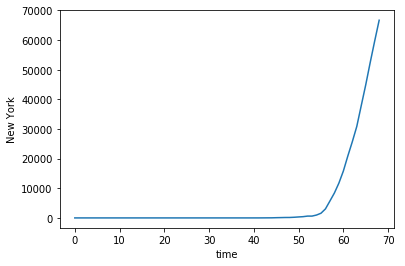

In [11]:
print(ds_US_states['New York'])
ds_US_states['New York'].plot()

In [12]:
def calc_growth_rate(cases):
    '''
    Calculates the exponential growth rate from first incidence of COVID19 to last recorded value
    Based on the formula:
        P(t) = A exp(k * t)
    Where P is the population at time t, A is the initial population value, and k is the growth rate.

            Parameters:
                total_cases (list): cumulative list of total cases

            Returns:
                k (float): calculated growth rate
    '''     
    i_0 = np.nonzero(cases)[0][0]
    
    P = cases[-1]
    A = cases[i_0]
    t = len(cases) - i_0 - 1 

    k = m.log(P / A) / t
    return k

In [13]:
k = calc_growth_rate(ds_US_states['New York'].values)
print(k)

0.3966930484053396


## Calculate Growth Rate in All States

In [14]:
ds_US_k = ds_US_states.copy()
for state in ds_US_states:
    if ds_US_states[state].values[-1] != 0:
        k = calc_growth_rate(ds_US_states[state].values)
        ds_US_k[state].attrs['growth_rate'] = k
    else:
        del ds_US_k[state]
        print('safe')
        
print(ds_US_k['Washington'])

safe
<xarray.DataArray 'Washington' (time: 69)>
array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    7,   11,   18,   27,   39,   70,   78,  102,  122,  122,
        167,  282,  442,  568,  642,  603,  779,  955, 1022, 1374, 1524, 1793,
       1997, 2221, 2328, 2591, 3207, 3477, 4030, 4465, 4923])
Dimensions without coordinates: time
Attributes:
    state:        Washington
    country:      US
    index:        1293
    growth_rate:  0.1250246085258559


## Compare to ERA5 temperature values

In [15]:
era5_dict = era5_state_dict
era5 = pd.read_csv(era5_dict['file']).to_xarray()

In [16]:
temps = [era5['2019-11'].values, era5['2019-12'].values, era5['2020-01'].values, era5['2020-02'].values]
mean_temps = np.mean(temps, axis = 0)

In [17]:
for state in ds_US_k:
    ds_US_k[state].attrs['mean_temp'] = mean_temps[ds_US_k[state].attrs['index']]
ds_US_k['Washington']

<xarray.DataArray 'Washington' (time: 69)>
array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    7,   11,   18,   27,   39,   70,   78,  102,  122,  122,
        167,  282,  442,  568,  642,  603,  779,  955, 1022, 1374, 1524, 1793,
       1997, 2221, 2328, 2591, 3207, 3477, 4030, 4465, 4923])
Dimensions without coordinates: time
Attributes:
    state:        Washington
    country:      US
    index:        1293
    growth_rate:  0.1250246085258559
    mean_temp:    2.3008194

In [18]:
growth_rates = []
mean_temps = []

for state in ds_US_k:
    growth_rates.append(ds_US_k[state].attrs['growth_rate'])
    mean_temps.append(ds_US_k[state].attrs['mean_temp'])

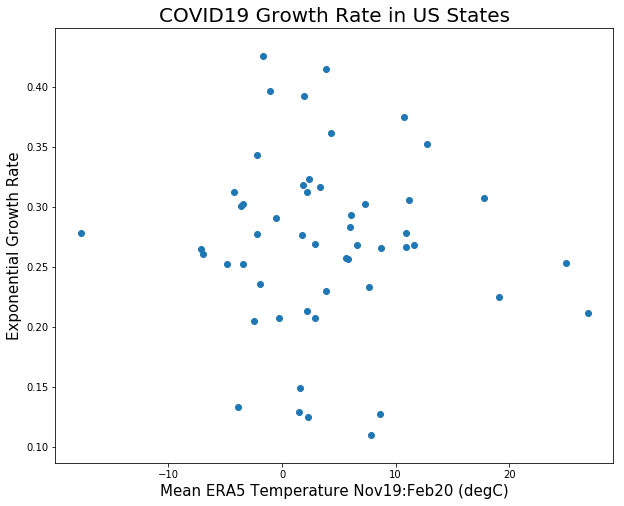

In [19]:
plt.figure(figsize=(10,8))
plt.scatter(mean_temps, growth_rates)
plt.title('COVID19 Growth Rate in US States', fontsize=20)
plt.xlabel('Mean ERA5 Temperature Nov19:Feb20 (degC)', fontsize=15)
plt.ylabel('Exponential Growth Rate', fontsize=15);